# Wind Power Prediction!

This problem is about predicting the normalized produced power of a wind turbine. The problem is part of a weekly assignment given by Pierre Pinson at Technical University of Denmark (DTU) within his course "Renewables at Electricity Markets". On a weekly basis, mr. Pinson assigned to his students the prediction of produced wind power in a given time range. 
You can check Pierre Pinson's awesome stuff on wind power forecasting at his personal [page](http://pierrepinson.com/)
In terms of this project, I will present a solution I made up on my own, for education purposes. On what's to come, I will show you some work on feature engineering, visualizations and predictive modelling. Furthermore, I will evaluate my model's prediction with the original values given by mr. Pinson with the root mean squared error of my predictions. First, I used a linear modelling approach for this problem and then I moved to an ensemble method (gradient boosting regression). So, stich with me on this, because it's gonna be tricky!!!

In [8]:
#Import all necessary modules (for now)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#load the data
traindata = pd.read_csv('TrainData3.csv')
forecast = pd.read_csv('WeatherForecastInput3.csv') 
solution = pd.read_csv('Solution3.csv')
#Take a look to the traindata and the forecast data
traindata.head()


,TIMESTAMP,POWER,U10,V10,U100,V100
0,20120101 1:00,0.378229,0.534894,-3.660243,0.765355,-4.486657
1,20120101 2:00,0.063012,0.330813,-2.676430,0.469875,-3.213752
2,20120101 3:00,0.036704,-0.065839,-2.029072,-0.020893,-2.418119
3,20120101 4:00,0.034342,-0.419549,-1.799090,-0.444867,-2.149654
4,20120101 5:00,0.033554,-0.754224,-1.661526,-0.838274,-1.991829


traindata contains the timestamp at which the measurement was taken, the measured power (normalized to 0-1 range) ,the horizontal and vertical speed at 10m and 100m respectively (U10,V10,U100,V100).Notice that the measurements are taken every hour in a from 1/1/2012 to 31/10/2013

In [3]:
forecast.head()

,TIMESTAMP,U10,V10,U100,V100
0,20131101 1:00,3.462251,-1.066374,4.323671,-1.330859
1,20131101 2:00,3.651341,-0.337717,4.532444,-0.451426
2,20131101 3:00,3.657829,0.328049,4.527268,0.341374
3,20131101 4:00,3.551698,0.735371,4.395563,0.818799
4,20131101 5:00,3.586921,1.050811,4.461128,1.251971


the forecast data contains the timestamp data to predict and the wind speed components for every hour from 1/11/2013 until 1/12/2013. 

My strategy is simple. I will manipulate the traindata, make up some features and then do the same manipulation to the forecast data. First, I need to calculate the resultant wind speed for every hour of the day. As we know from common physics, the resultan power of two vertical components x and y is the square root of the sum of their squares.

In [9]:
traindata['WS10'] = np.sqrt(traindata['U10']**2 + traindata['V10']**2)
traindata['WS100'] = np.sqrt(traindata['U100']**2 + traindata['V100']**2)

I figured out that the average height of the widely used wind-turbines is about [65m](https://www.wind-watch.org/faq-size.php). Since I don't know the exact height of the specific turbine, I chose to create another feature: the wind speed at 65m. I used the wind power profile law, as it is given at [wiki](https://en.wikipedia.org/wiki/Wind_profile_power_law). 

In [10]:
traindata['WS65'] = traindata.WS100*0.65**((np.log(traindata.WS100)-np.log(traindata.WS10))/(np.log(100)-np.log(10)))

Furthermore, since I know the wind speed componets, is easy for me to calculate the angle that these two components have between them.Numpy was more than once a faithful companio in my quest:

In [11]:
#Calculate wind angle 10m
traindata['angle_10'] = np.arctan(traindata.V10/traindata.U10)   
traindata['angle_10'] = np.degrees(traindata['angle_10'])
#Calculate  wind angle 100m
traindata['angle_100'] = np.arctan(traindata.V100/traindata.U100)   
traindata['angle_100'] = np.degrees(traindata['angle_100'])


What is more, I came up with the idea of transforming the "TIMESTAMP" column to timedate and extract the "hour" component. I found it a good idea, since the measurements were taken every hour of the day.

In [12]:
traindata.TIMESTAMP =pd.to_datetime(traindata.TIMESTAMP) 
traindata['hour'] = traindata.TIMESTAMP.dt.hour

While studying on this problem, I checked mr. Pinson's lectures. Luckily enough, mr. Pinson provided some hints to his students. One hints was the concept of calculating wind speed harmonics. Since I had already calculated the wind speed angle for every measurement, it was really simple to calculate its harmonics for every given height. Firstly, I transformed angle value to be positive (as the difference from 360 degrees) and then I calculated their harmonics with the formula provided. 

In [13]:
from numpy import cos,sin,pi

traindata['angle_10'] = np.where(traindata['angle_10'] < 0 , 360-abs(traindata['angle_10']), traindata.angle_10)
traindata['angle_100'] = np.where(traindata['angle_100'] < 0 , 360-abs(traindata['angle_100']), traindata.angle_100)
traindata['cos_10'] = cos((2*pi*(traindata['angle_10']))/360)
traindata['sin_10'] = sin((2*pi*(traindata['angle_10']))/360)
traindata['cos_100'] = cos((2*pi*(traindata['angle_100']))/360)
traindata['sin_100'] = sin((2*pi*(traindata['angle_100']))/360)

After all these steps, I checked the correlation of my variables with the target value (POWER). 

In [69]:
corr_power = traindata.corr().POWER
corr_power = corr_power.sort_values(ascending = False)
corr_power

POWER             1.000000
WS65              0.809666
WS100             0.808623
WS10              0.761842
U100              0.411380
U10               0.411126
angle_100         0.068262
angle_10          0.056155
hour              0.014203
harmonic_1_100    0.012895
harmonic_1_10    -0.000856
harmonic_2_10    -0.086742
harmonic_2_100   -0.103902
V10              -0.198619
V100             -0.208321
Name: POWER, dtype: float64

Next step, is the creation of polynomial variables from my features. I took the three most correlated variables, and added their square root, squares and cubes to my dataset.

In [14]:
traindata['WS10^2'] = traindata['WS10']**2
traindata['WS10^3'] = traindata['WS10']**3


traindata['WS100^2'] = traindata['WS100']**2
traindata['WS100^3'] = traindata['WS100']**3


traindata['WS65^2'] = traindata['WS65']**2
traindata['WS65^3'] = traindata['WS65']**3

traindata.head()

,TIMESTAMP,POWER,U10,V10,U100,V100,WS10,WS100,WS65,angle_10,...,cos_10,sin_10,cos_100,sin_100,WS10^2,WS10^3,WS100^2,WS100^3,WS65^2,WS65^3
0,2012-01-01 01:00:00,0.378229,0.534894,-3.660243,0.765355,-4.486657,3.699120,4.551468,4.378283,278.314135,...,0.144600,-0.989490,0.168156,-0.985760,13.683492,50.616887,20.715863,94.287595,19.169359,83.928873
1,2012-01-01 02:00:00,0.063012,0.330813,-2.676430,0.469875,-3.213752,2.696797,3.247920,3.136872,277.046157,...,0.122669,-0.992448,0.144669,-0.989480,7.272714,19.613031,10.548987,34.262272,9.839966,30.866715
2,2012-01-01 03:00:00,0.036704,-0.065839,-2.029072,-0.020893,-2.418119,2.030140,2.418209,2.340353,88.141536,...,0.032431,0.999474,0.008640,0.999963,4.121468,8.367156,5.847736,14.141050,5.477250,12.818697
3,2012-01-01 04:00:00,0.034342,-0.419549,-1.799090,-0.444867,-2.149654,1.847362,2.195203,2.125483,76.873170,...,0.227107,0.973870,0.202654,0.979250,3.412745,6.304574,4.818918,10.578504,4.517679,9.602251
4,2012-01-01 05:00:00,0.033554,-0.754224,-1.661526,-0.838274,-1.991829,1.824698,2.161038,2.093712,65.585050,...,0.413342,0.910576,0.387903,0.921700,3.329523,6.075375,4.670084,10.092229,4.383628,9.178053


Next, the same manipulation was made for the forecast data. 

In [15]:
#Wind Speed 10 and 100m.
forecast['WS10'] = np.sqrt(forecast['U10']**2 + forecast['V10']**2)
forecast['WS100'] = np.sqrt(forecast['U100']**2 + forecast['V100']**2)
#Wind Speed 70m height
forecast['WS70'] = forecast.WS100*0.65**((np.log(forecast.WS100)-np.log(forecast.WS10))/(np.log(100)-np.log(10)))

#Calculate wind angle 10m
forecast['angle_10'] = np.arctan(forecast.V10/forecast.U10)   
forecast['angle_10'] = np.degrees(forecast['angle_10'])
forecast['angle_10'] = np.where(forecast['angle_10'] < 0, 360-abs(forecast.angle_10),forecast.angle_10)
#Calculate  wind angle 100m
forecast['angle_100'] = np.arctan(forecast.V100/forecast.U100)   
forecast['angle_100'] = np.degrees(forecast['angle_100'])
forecast['angle_100'] = np.where(forecast['angle_100'] < 0, 360-abs(forecast.angle_100),forecast.angle_100)

#take the hour of the forecast
forecast.TIMESTAMP =pd.to_datetime(forecast.TIMESTAMP) 
forecast['hour'] = forecast.TIMESTAMP.dt.hour

#Calculate Harmonics
forecast['cos_10'] = cos((2*pi*(forecast['angle_10']))/360)
forecast['sin_10'] = sin((2*pi*(forecast['angle_10']))/360)
forecast['cos_100'] = cos((2*pi*(forecast['angle_100']))/360)
forecast['sin_100'] = sin((2*pi*(forecast['angle_100']))/360)

#take WS powers (2,3)
forecast['WS10-s2'] = forecast['WS10']**2
forecast['WS10-s3'] = forecast['WS10']**3


forecast['WS100-s2'] = forecast['WS100']**2
forecast['WS100-s3'] = forecast['WS100']**3


forecast['WS70-s2'] = forecast['WS70']**2
forecast['WS70-s3'] = forecast['WS70']**3

forecast.head()

,TIMESTAMP,U10,V10,U100,V100,WS10,WS100,WS70,angle_10,angle_100,...,cos_10,sin_10,cos_100,sin_100,WS10-s2,WS10-s3,WS100-s2,WS100-s3,WS70-s2,WS70-s3
0,2013-11-01 01:00:00,3.462251,-1.066374,4.323671,-1.330859,3.622753,4.523861,4.339712,342.881154,342.891229,...,0.955696,-0.294355,0.955748,-0.294187,13.124340,47.546241,20.465319,92.582258,18.833100,81.730231
1,2013-11-01 02:00:00,3.651341,-0.337717,4.532444,-0.451426,3.666925,4.554870,4.373783,354.715682,354.312173,...,0.995750,-0.092098,0.995077,-0.099108,13.446341,49.306728,20.746836,94.499132,19.129981,83.670391
2,2013-11-01 03:00:00,3.657829,0.328049,4.527268,0.341374,3.672510,4.540120,4.363509,5.124816,4.312166,...,0.996002,0.089326,0.997169,0.075190,13.487329,49.532352,20.612692,93.584104,19.040210,83.082124
3,2013-11-01 04:00:00,3.551698,0.735371,4.395563,0.818799,3.627028,4.471175,4.299529,11.697669,10.552027,...,0.979231,0.202747,0.983089,0.183128,13.155329,47.714741,19.991402,89.385051,18.485953,79.480899
4,2013-11-01 05:00:00,3.586921,1.050811,4.461128,1.251971,3.737673,4.633475,4.450929,16.328281,15.676247,...,0.959667,0.281140,0.962804,0.270201,13.970203,52.216058,21.469093,99.476513,19.810767,88.176310


### Outlier detection!

Next, I will clean my data. While checking scatterplots between different wind speeds and the produced power, I discovered wind speed values acting a little weird. Let's check those plots and see what we'll find!

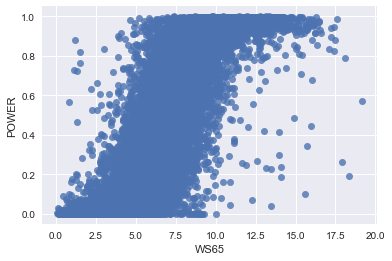

In [72]:
sns.regplot(traindata.WS65,traindata.POWER,fit_reg=False)
plt.show()

Since there are 16080 values in my traindata, I will choose to drop a bunch of them. In this case, I will drop all values that have a wind speed at 65m that is lower than 2.5 m/s and have produced power greater than 0.7. Furthermore, I will drop all values that have a wind speed greater than 12.5 m/s that produced power less than 0.6. 

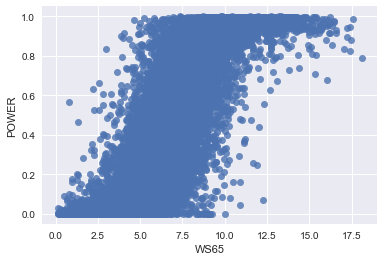

In [16]:
traindata.drop(traindata[(traindata['WS65'] > 12.5) & (traindata['POWER'] < 0.6)].index, inplace = True)
traindata.drop(traindata[(traindata['WS65'] < 2.5) & (traindata['POWER'] > 0.7)].index, inplace = True)

sns.regplot(traindata.WS65,traindata.POWER,fit_reg=False)
plt.show()

My quest on wind speed-power outliers will be continued on the scatterplot for the WS100 feature. Since it's the 2nd most correlated variable, I have to take a look.

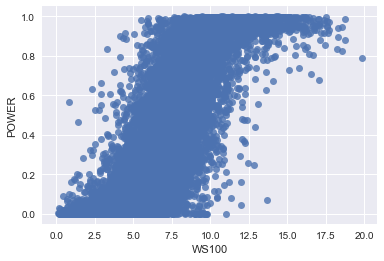

In [74]:
sns.regplot(traindata.WS100,traindata.POWER,fit_reg=False)
plt.show()

It seems to me, that the cleaning of the WS65 outliers worked at this feature as well. But, I will take it one step further and apply the same filters to this feature. 

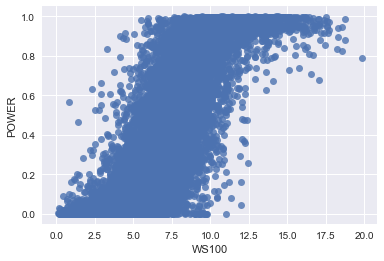

In [17]:
traindata.drop(traindata[(traindata['WS100'] > 12.5) & (traindata['POWER'] < 0.6)].index, inplace = True)
traindata.drop(traindata[(traindata['WS100'] < 2.5) & (traindata['POWER'] > 0.7)].index, inplace = True)

sns.regplot(traindata.WS100,traindata.POWER,fit_reg=False)
plt.show()

Very well. Now I will move to the modelling procedure. 

### Let's predict!

Since I have to deal with time-series data, I had to find a sophisticated way to apply cross-validation to my data. While working on this subject, I found a really useful blog from mr.Pochetti. In that blog, mr.Pochetti suggested a really Pythonic method to cross-validate time-series data. Mr. Pochetti, used his method for a classification task, so I had to modify some parts of the code, in order to make it work for my regression problem. The original post from mr.Pochetti can be found [here](http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/)
The "perfromTimeSeriesCV" function, separates a train set to a number of chunks and cross-validates one chunk at a time adding one more fold in each iteration. When the iterations are over, the function returns the mean of root absolute errors it calculated in each iteration. Confused? Take a look!



In [18]:
def performTimeSeriesCV(X_train, y_train, number_folds, model):

    print( 'Size train set: ', X_train.shape)
    
    # k is the size of each fold. It is computed dividing the number of 
    # rows in X_train by number_folds. This number is floored and coerced to int.
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print ('Size of each fold: ', k)
    
    #It is important to stress that in the CV of Time Series if I have n folds I test n-1 folds as the first
    # one is always needed to train
    mse = np.zeros(number_folds-1)
 
    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print ('')
        
        # the split is the percentage at which to split the folds into train
        # and test. For example when i = 2 we are taking the first 2 folds out 
        # of the total available. In this specific case we have to split the
        # two of them in half (train on the first, test on the second), 
        # so split = 1/2 = 0.5 = 50%. When i = 3 we are taking the first 3 folds 
        # out of the total available, meaning that we have to split the three of them
        # in two at split = 2/3 = 0.66 = 66% (train on the first 2 and test on the
        # following)
        split = float(i-1)/i
        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print ('Size of train + test: ', X.shape) # the size of the dataframe is going to be k*i
 
        # X and y contain both the folds to train and the fold to test.
        # index is the integer telling us where to split, according to the
        # split percentage we have set above
        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        model = model.fit(X_train,y_train)
        preds = model.predict(X_testFold)
        mse[i-2]= mean_squared_error(y_testFold,preds)
        # i starts from 2 so the zeroth element in accuracies array is i-2.              
        print ('MSE on fold ' + str(i) + ': ', mse[i-2])
    
    # the function returns the root of the mean squarred error of the whole trainset     
    return np.sqrt(mse.mean())


The two linear methods I applied to predict were:  
1.OLS (ordinary-least-squares) regression (typical Linear Regression) 
2.Lasso Regression (which is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces). 

In [19]:
#Drop Timestamp columns
solution = solution.drop('TIMESTAMP',axis=1)

traindata = traindata.drop('TIMESTAMP',axis = 1)

forecast = forecast.drop('TIMESTAMP',axis = 1)



In [22]:
X = traindata.drop('POWER',axis=1)
Y = traindata.POWER

from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import mean_squared_error

OLS = LinearRegression()
#choose a relatively small alpha for my Lasso model (took some trials)
lasso = Lasso(alpha = 1e-6)

#Classic Linear Regression Model
train_rmse_OLS = performTimeSeriesCV(X,Y,10,OLS)
#Forecast!!!!
predictions_linear_regression = OLS.predict(forecast)
#Set negative values to zero and above 1 values to 1
predictions_linear_regression = np.where(predictions_linear_regression > 1, 1, predictions_linear_regression)
predictions_linear_regression = np.where(predictions_linear_regression < 0, 0, predictions_linear_regression)
#Calculate root mean squarred error for our solution
rmse_OLS = np.sqrt(mean_squared_error(solution,predictions_linear_regression))

#Lasso Model
train_rmse_lasso = performTimeSeriesCV(X,Y,10,lasso)
#Forecast!!!!
predictions_Lasso = lasso.predict(forecast)
#Set negative values to zero and above 1 values to 1
predictions_Lasso = np.where(predictions_Lasso > 1, 1, predictions_Lasso)
predictions_Lasso = np.where(predictions_Lasso < 0, 0, predictions_Lasso)
#Calculate root mean squarred error for our solution
rmse_Lasso = np.sqrt(mean_squared_error(solution,predictions_Lasso))
 
print('Train Errors')
print('OLS:%.3f'%(train_rmse_OLS*100),'%','Lasso:%.3f'%(train_rmse_lasso*100),'%')
print('-------------------------')
print('-------------------------')
print('Root Mean Squared Error at predictions')
print('OLS:%.3f'%(rmse_OLS*100),'%','Lasso:%.3f'%(rmse_Lasso*100),'%')

Size train set:  (16055, 20)
Size of each fold:  1605

Size of train + test:  (3210, 20)
MSE on fold 2:  0.0273873357412

Size of train + test:  (4815, 20)
MSE on fold 3:  0.0276202360374

Size of train + test:  (6420, 20)
MSE on fold 4:  0.0266445094494

Size of train + test:  (8025, 20)
MSE on fold 5:  0.0301218051875

Size of train + test:  (9630, 20)
MSE on fold 6:  0.0277804022043

Size of train + test:  (11235, 20)
MSE on fold 7:  0.0351936107215

Size of train + test:  (12840, 20)
MSE on fold 8:  0.0323457338157

Size of train + test:  (14445, 20)
MSE on fold 9:  0.0201380147423

Size of train + test:  (16050, 20)
MSE on fold 10:  0.0292684009135
Size train set:  (16055, 20)
Size of each fold:  1605

Size of train + test:  (3210, 20)


C:\Users\Riko\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


MSE on fold 2:  0.0276692745454

Size of train + test:  (4815, 20)
MSE on fold 3:  0.0283735632682

Size of train + test:  (6420, 20)
MSE on fold 4:  0.0272733248955

Size of train + test:  (8025, 20)
MSE on fold 5:  0.0301801311009

Size of train + test:  (9630, 20)
MSE on fold 6:  0.0275567581188

Size of train + test:  (11235, 20)
MSE on fold 7:  0.0349807392484

Size of train + test:  (12840, 20)
MSE on fold 8:  0.0330828060157

Size of train + test:  (14445, 20)
MSE on fold 9:  0.0204425912842

Size of train + test:  (16050, 20)
MSE on fold 10:  0.0298294099135
Train Errors
-------------------------
OLS:16.882 % Lasso:16.977 %
-------------------------
Root Mean Squared Error at predictions
OLS:16.858 % Lasso:16.857 %


In the next two plots, I want to eyeball the coefficients my models developed. Lasso regression penalizes some features with zero coefficients and I'll take a better view on the feature engineering procedure I worked earlier.

Lasso picked 20 features and eliminated the other 0 features


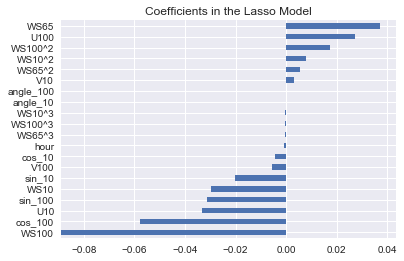

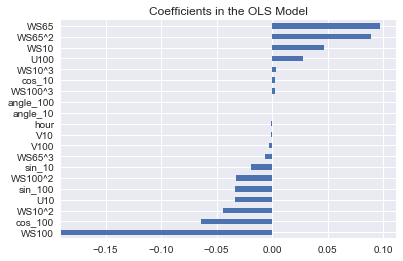

In [23]:
coefs = pd.Series(lasso.coef_, index = X.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " + str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()



coefs = pd.Series(OLS.coef_, index = X.columns)
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the OLS Model")
plt.show()


###Ensemble method!
Well..so far so good!Linear modelling, did really well. I predicted produced wind power with about 16.86% rmse. It's a really good start and what I can say from it is that probably, if I choose to "massage" traindata a little more, linear models might score an even lower error. The really good thing about linear models is how quick they are. 

Next, I will test how well an ensembled regressor fits to my problem.
First, a few words on gradient boosting algorithm. The word "boosting" refers to the conversion of weak learnes into strong ones. Gradient boosting algorithm, trains many models at the same time, while every model minimizes the loss function of the whole system. The learning procedure consecutively fit new models to provide a more accurate estimate of the response variable.
Because ensembled methods are significantly slower in relatively large datasets, I will tune my model based on some assumptions I made on my data. So, I choose to create 300 estimators. This method is very good against overfitting, if I raise the estimators number I will probably end up with a slightly more accurate but significantly slower model. Furthermore, I set the "max_depth" at 5.  The max_depth parameter is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample. Since I use the "performTimeSeriesCV" function to perform cross-validation, I want my model to be exposed to complex relations among my variables. So the number "5" would be ok (default sci-kit learn value: 3). The "min_samples_split" parameter is also used to control over-fitting.Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.Since the default value is 2, I set it to 10 to make my model better at generalization. The learning rate is used to determine the impact of each tree in the final outcome.I'm using a default value 10 times lower than the default one, so that my model is more robust to the specific characteristics of each tree. Finally, the "loss" parameter refers to the loss function to be used on the algorithm evaluation process, in this case, I'm using 'ls' which is the least-squares function (similar to the OLS method used earlier). A terrific guide to parameter tuning for gradient boosting algorithm can be found in my favorite [analytics vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
params_gb = {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 20,
          'learning_rate': 0.01, 'loss': 'ls'}
GB = GradientBoostingRegressor(**params_gb)
train_rmse_GB = performTimeSeriesCV(X,Y,10,GB)
pred_GB = GB.predict(forecast)

rmse_GB = np.sqrt(mean_squared_error(solution,pred_GB))
print('Train RMSE Gradient Boost %.3f'%(train_rmse_GB*100),'%')
print('-----------------------------------------------------------')
print("RMSE Gradient Boost %.3f"%(rmse_GB*100),'%')


Size train set:  (16055, 20)
Size of each fold:  1605

Size of train + test:  (3210, 20)
MSE on fold 2:  0.0225760848211

Size of train + test:  (4815, 20)
MSE on fold 3:  0.0241197387449

Size of train + test:  (6420, 20)
MSE on fold 4:  0.0216750414744

Size of train + test:  (8025, 20)
MSE on fold 5:  0.0248277127641

Size of train + test:  (9630, 20)
MSE on fold 6:  0.0235782630785

Size of train + test:  (11235, 20)
MSE on fold 7:  0.0297547733728

Size of train + test:  (12840, 20)
MSE on fold 8:  0.0274524774849

Size of train + test:  (14445, 20)
MSE on fold 9:  0.0179220460199

Size of train + test:  (16050, 20)
MSE on fold 10:  0.0244506325665
Train RMSE Gradient Boost 15.505 %
-----------------------------------------------------------
RMSE Gradient Boost 16.724 %


As you can see, the Gradient Boosting Method with this specific tuning, had a reduced rmse (by 0.1%). This may not seem a significant improvement in terms of absolute numbers but given that this method is accompanied by a feature importance attribute, we can see a significant advantage of ensembled methods againts linear statistical modelling.
Now, let's check how important each feature were for my model. By doing so, I can evaluate more thoroughly my first steps and see which features my algorithm paid more attention to. I can obtain a more solid image of the way the GB method handled this problem and visit this problem again to work with the input data. 

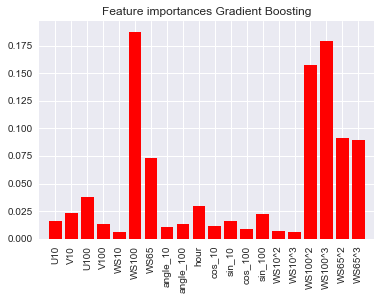

In [25]:
importances_GB = GB.feature_importances_
plt.figure()
plt.title("Feature importances Gradient Boosting")
plt.bar(range(X.shape[1]), importances_GB,
       color="g",align="center")
plt.bar(range(X.shape[1]), importances_GB,
       color="r",align="center")
plt.xticks(range(X.shape[1]), X.columns)
plt.xlim([-1, X.shape[1]])
plt.tight_layout
plt.xticks(rotation = 90 )
plt.show()

Notice the importance GB algorithm gave to each and everyone feature. Bear in mind that this dataset had 4 features in the beginning and ended up with 20. Furthermore, one can see that the polynomial features were really important to our model's decision. On the other hand, low height speed(10m) was not that important as well as the harmonic features I created. I can use this plot directionally, to revisit the features I created for this project. For example, since the polynomial features appear to be more important, I could try to create some more. On the other hand, since the harmonic and the low-height speed features  scored way below 0.05% I could try to run the model without them. In any case, I've made a step further towards forecasting produced power from windturbines. 
I hope you enjoyed this project. Feel free to comment, share and discuss this project. I'm really enthusiastic about discussing this awesome stuff with anyone interested, help and get helped!

See ya!